# Modelo SVM (Support Vector Machine)

Añadir todas las librerias necesarias para el entrenamiento y visualización de los datos.

In [2]:

#Visualizar las metricas del modelo
import matplotlib.pyplot as plt

#Libreria para manipular archivos
import os 
import sys

#Libreria que divide en test y train el dataset, permite usar Grid Search
#para revisar hiperparametros e incluye Stratified Kfold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.svm import SVC


Importar funciones

In [3]:
sys.path.append(os.path.abspath("../funciones"))
from funcionesEntrenamiento import (
    cargar_datos_entrenamiento,
    cargar_datos_prueba,
    imprimir_forma,
    division_train_val,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
    hacer_pepinillo
)

Cargar Dataset

In [4]:
X, y = cargar_datos_entrenamiento()
shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

Shape:  (1500, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,tag_Bulimia,tag_ED,tag_RexyBill,tag_Salud,tag_TCA,tag_Thinspo,tag_adelgazar,tag_alimentacionsaludable,tag_ana,tag_anamia,tag_anorexia,tag_anorexiaeetclub,tag_anorexic,tag_bulimia,tag_bulimianervosa,tag_bulimic,tag_bulimicgirl,tag_comida,tag_comidasaludable,tag_comidasana,tag_deporte,tag_desayuno,tag_dieta,tag_eatclean,tag_ed,tag_ejercicio,tag_entrenamiento,tag_fat,tag_fit,tag_food,...,tfidf_1260,tfidf_1261,tfidf_1262,tfidf_1263,tfidf_1264,tfidf_1265,tfidf_1266,tfidf_1267,tfidf_1268,tfidf_1269,tfidf_1270,tfidf_1271,tfidf_1272,tfidf_1273,tfidf_1274,tfidf_1275,tfidf_1276,tfidf_1277,tfidf_1278,tfidf_1279,tfidf_1280,tfidf_1281,tfidf_1282,tfidf_1283,tfidf_1284,tfidf_1285,tfidf_1286,tfidf_1287,tfidf_1288,tfidf_1289,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,0.242191,-0.059671,0,0,0,0,0,1.173738,0.353420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.549985,-1.624910,0,0,0,0,0,-0.336367,-1.128151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.456454,-0.283276,3,2,0,0,0,0.796212,0.946048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333319,0.163935,0,0,0,1,0,1.777780,0.649734,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.790588,-0.730488,0,0,0,1,0,-1.317935,0.946048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dividir dataset, separando caracteristicas y etiquetas

Generamos la separación del dataset para su validación; teniendo en cuenta que tenemos varios casos donde la etiqueta no será detección de problema mental usaremos stratify para mantener una proporcion adecuada en cada entrenamiento. Usando un split de 80 20 para train y test respectivamente y un random state de 22 el cual se mantendrá igual en cada uno.

In [5]:
X_train, X_val, y_train, y_val = division_train_val(X, y)
train_shape, _ = imprimir_forma (X_train)
val_shape, _ = imprimir_forma(X_val)

print(f'Forma de conjunto de entrenamiento: {train_shape}')
print(f'Forma de conjunto de validacion: {val_shape}')

Forma de conjunto de entrenamiento: (1200, 1368)
Forma de conjunto de validacion: (300, 1368)


## Entrenamiento inicial de SVM

In [9]:
svm_inicial = SVC(random_state=22, probability=True)
scores = cross_val_score(svm_inicial, X_train, y_train, cv=5, scoring='roc_auc')

print("Resultados por fold:", scores)
print("Precisión promedio:", scores.mean())

Resultados por fold: [0.89971367 0.87994972 0.86269991 0.86314174 0.9347447 ]
Precisión promedio: 0.8880499466516454


In [10]:
svm_inicial.fit(X_train, y_train)

SVC(probability=True, random_state=22)

In [11]:
y_pred_inicial, y_proba_inicial, reporte_inicial = reporte_clasificacion(X_val, y_val, svm_inicial)

print("Classification Report:")
print(reporte_inicial)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.77       139
           1       0.78      0.90      0.84       161

    accuracy                           0.81       300
   macro avg       0.82      0.80      0.81       300
weighted avg       0.82      0.81      0.81       300



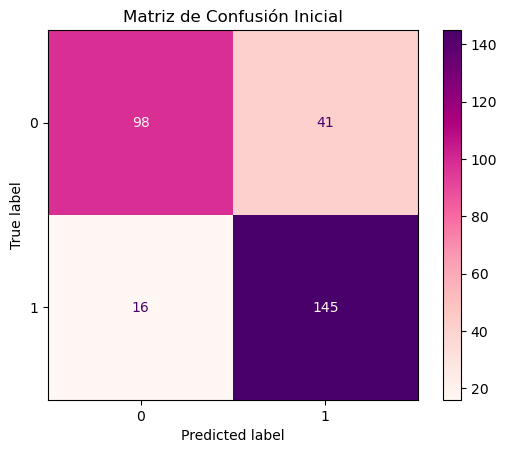

In [12]:
cm_inicial, disp_inicial = crear_matriz_confusion(y_val, y_pred_inicial)
disp_inicial.plot(cmap='RdPu')
plt.title("Matriz de Confusión Inicial")
plt.show()

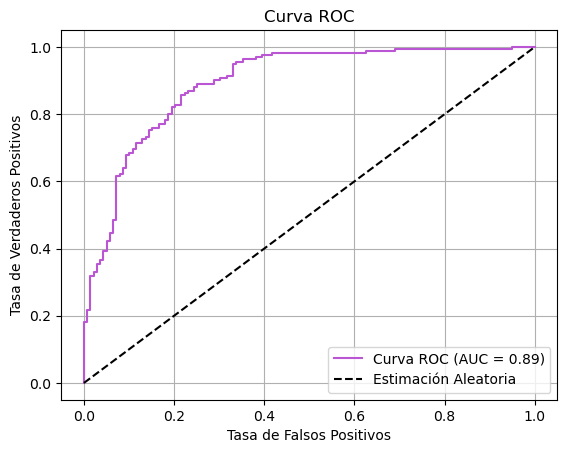

In [13]:
fpr_inicial, tpr_inicial, thresholds_inicial, auc_score_inicial = calcular_roc_auc(y_val, y_proba_inicial)

plt.figure()
plt.plot(fpr_inicial, tpr_inicial, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score_inicial:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [14]:
TPR_inicial, FPR_inicial = metricas_tpr_fpr(cm_inicial)

# Mostrar métricas
print(f"AUC: {(auc_score_inicial * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR_inicial * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_inicial * 100):.4f}")

AUC: 89.2935
TPR (Tasa de Positivos Verdaderos): 90.0621
FPR (Tasa de Falsos Positivos): 29.4964


## Búsqueda de mejores parámetros (Entrenamiento y Validación)

* Guardamos el modelo SVM en una variable con el mismo random state que previamente
* Creamos los hiperparametros objetivos para poder realizar el gridsearch, buscando el mejor para el entrenamiento.
* Generamos un crossvalidation que use 5 splits y de esta manera poder generar un balance adecuado de clases.

In [ ]:
model = SVC(random_state=22)

hyperparam_grid = {
    'C': [300, 350, 400, 450, 500],
    'gamma': [0.0005, 0.001, 0.012, 0.014, 0.016],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=22
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=hyperparam_grid,
    refit = True,
    verbose = 3,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv = cv,
    error_score='raise'
)


Iniciamos el Grid Search

* Usamos el modelo de svc para estimar durante el grid search.
* Con los hiperparametros elegidos realizamos el barrido.
* Usamos refit para ajustar el grid search al mejor valor posible durante entrenamiento.
* Con verbose = 3 podremos entender durante el entrenamiento como van cambiando los valores del mismo.
* La metrica a revisar será la area debajo de la curva para estimar cuales son los mejores hiperparametros para entrenar nuestro modelo.
* Con n_jobs = -1 nos permite usar todos los procesadores en paralelo, lo que permite un entrenamiento más rápido usando más recursos de la máquina.
* El cross validation que usaremos será con stratified kfolds, donde el objetivo será balancear el entrenamiento para que sea representativo de cada clase durante el entrenamiento.
* El error_score en raise nos va a arrojar errores si hay algun problema durante el entrenamiento, lo que nos ayuda al debug de errores en caso de que haya alguno.

In [8]:
grid_search.fit(X_val, y_val)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             error_score='raise', estimator=SVC(random_state=22), n_jobs=-1,
             param_grid={'C': [400, 410], 'gamma': [0.001], 'kernel': ['rbf']},
             scoring='roc_auc', verbose=3)

In [9]:
grid_search.best_params_

{'C': 400, 'gamma': 0.001, 'kernel': 'rbf'}

Con los valores de los hiperparametros seleccionados creamos el modelo de SVM con los mejores.

In [ ]:
best_SVM = SVC(
    C = 400,
    gamma = 0.001,
    kernel = 'rbf',
    probability= True,
    random_state = 22
)

best_SVM.fit(X_train, y_train)

SVC(C=410, gamma=0.001, probability=True, random_state=22)

Empezamos a predecir usando el modelo con el set de validación e imprimimos los resultados.

In [12]:
y_pred, y_proba, reporte = reporte_clasificacion(X_val, y_val, best_SVM)

print("Classification Report:")
print(reporte)


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       139
           1       0.87      0.89      0.88       161

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



Con los resultados generaremos una matriz de confusión para poder observar los Falsos Positivos, Verdaderos Positivos, Verdaderos Negativos y Falsos Negativos.

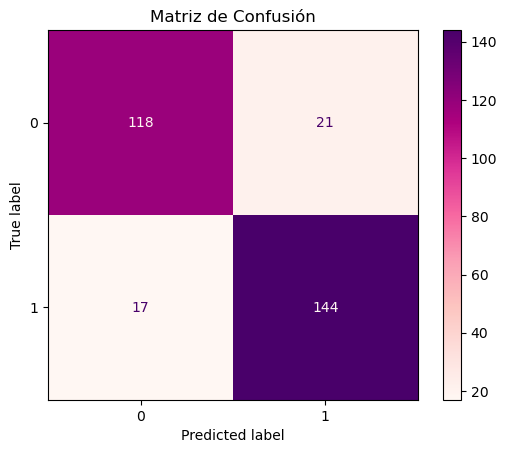

In [13]:
cm, disp = crear_matriz_confusion(y_val, y_pred)
disp.plot(cmap="RdPu")
plt.title("Matriz de Confusión")
plt.show()

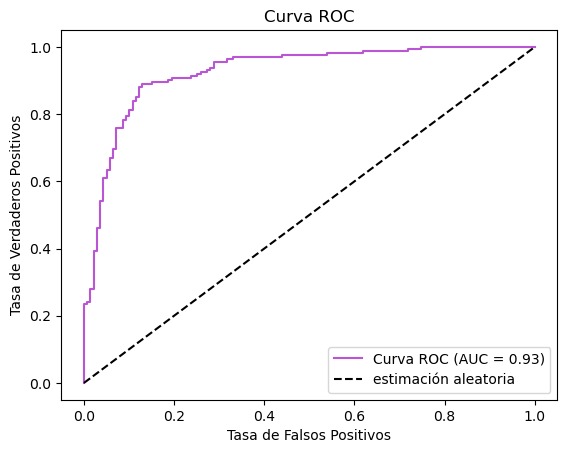

In [14]:
# Predicciones de scores (para curva ROC)
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_val, y_proba)

# Gráfica de ROC
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


In [15]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 92.6002
TPR (Tasa de Verdaderos Positivos): 89.4410
FPR (Tasa de Falsos Positivos): 15.1079


## Modelo Final (Entrenamiento y Prueba)

In [16]:
modelSVM = SVC(
          C=400, 
          gamma=0.001, 
          kernel='rbf', 
          probability=True,
          random_state= 22
          )
modelSVM.fit(X, y)

SVC(C=400, gamma=0.001, probability=True, random_state=22)

In [17]:
X_test, y_test = cargar_datos_prueba()

shape_test, head_test = imprimir_forma(X_test)
print("Shape test: ",shape_test)
head_test

Shape test:  (250, 1368)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1290,tfidf_1291,tfidf_1292,tfidf_1293,tfidf_1294,tfidf_1295,tfidf_1296,tfidf_1297,tfidf_1298,tfidf_1299
0,-0.395702,-0.506882,0,1,0,0,0,0.972391,1.341134,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.338126,2.399991,0,1,0,1,1,-0.185357,0.538616,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.881716,-0.730488,2,2,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.181439,-0.283276,1,3,0,1,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.338126,3.294413,1,3,0,0,0,-0.336367,-1.128151,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y_pred_test, y_proba_test, reporte_test = reporte_clasificacion(X_test, y_test, modelSVM)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       116
           1       0.81      0.93      0.86       134

    accuracy                           0.84       250
   macro avg       0.85      0.83      0.84       250
weighted avg       0.85      0.84      0.84       250



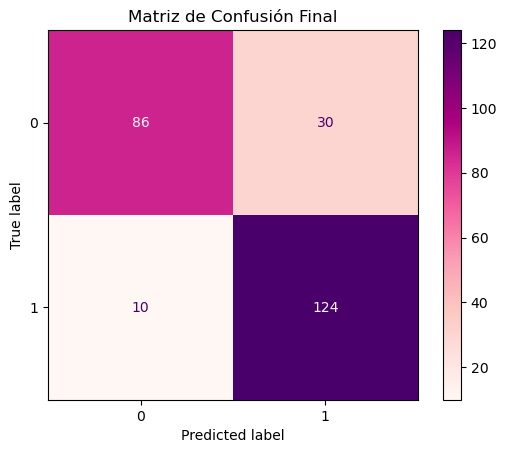

In [19]:
cm_test, disp_test = crear_matriz_confusion(y_test, y_pred_test)
disp_test.plot(cmap='RdPu')
plt.title("Matriz de Confusión Final")
plt.show()

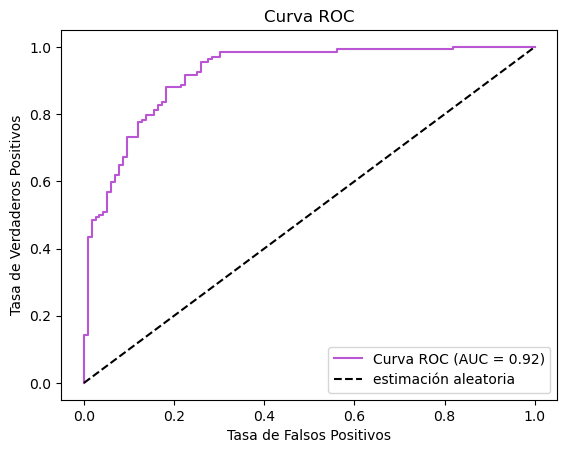

In [20]:
# Predicciones de scores (para curva ROC)
fpr_test, tpr_test, thresholds_test, auc_score_test = calcular_roc_auc(y_test, y_proba_test)

# Gráfica de ROC
plt.plot(fpr_test, tpr_test, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score_test:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


In [21]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_Test, FPR_Test = metricas_tpr_fpr(cm_test)

# Mostrar métricas
print(f"AUC: {(auc_score_test * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR_Test * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_Test * 100):.4f}")

AUC: 92.0033
TPR (Tasa de Verdaderos Positivos): 92.5373
FPR (Tasa de Falsos Positivos): 25.8621


Guardado del modelo final en un archivo pickle

In [22]:
hacer_pepinillo(modelSVM, "modelSVM.pkl")